#  Problem 1 : Investigating what features influenece time to become pregnant and dropout rate on real NC data.

## Summary
I decided to approach this as a classification problem. I have looked at what features influence whether a cycler becomes pregnant/dropout before or after a threshold number of mmonths of using the NC app. I assume that "DaysTrying" is the amount of time the cycler has been using the app. 

<br>To do this I split the data into two sets. One set is pregnant, and the other set are dropouts. The importance of the features that help the algorithm to decide if a cycler will conceive before a certain threshold of months,N, will provide information about the factors that impact the time it takes to become pregnant. Similarly the importance of the features that help the algorithm to decide if a cycler will dropout before N months should be the ones that impact the time a cycler sticks with NC before dropping out. In both cases I found that the two most important features are **Sex Logging Frequency** and **Temperature Logging Frequency**. I concluded that these are the most important features because they have an implicit time dependence that I did not consider in setting up the problem.

### Caveat
<br> While I chose this approch because it is what I am most familiar with, I acknowledge that it is not the most obvious or intuitive one. It would be more logical to approach this as a regression problem, trying to find which features are important for assigning a value of DaysTrying to a cycler for example. I chose to use a Random Forest Classifier because I have some understanding of how it works and I that it can give good results even without needing to play too much with the hyper parameters. A major drawback of using the scikitlearn RandomForestClassifier is it is not possible to do partial dependence plots, therefore it will be difficult to judge the sense in which features are important.


In [420]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from pandas.plotting import scatter_matrix

np.random.seed(123)
plt.rcParams["font.size"] = 14
plt.rcParams["figure.figsize"] = (4, 4)

## Load and view data

In [38]:
data = pd.read_csv('anafile_challenge_170522.csv', header=0, sep=',')
#data = pd.read_csv('one hot pregnant.csv', header=0, sep=',')
data.head()

,Country,Age,NumBMI,Pill,NCbefore,FPlength,Weight,CycleVar,TempLogFreq,SexLogFreq,DaysTrying,CyclesTrying,ExitStatus,AnovCycles
0,SE,24,22.920971,NULL,FALSE,normal,71.0,regular,0.701149,0.448276,86,2,Pregnant,0
1,SE,34,18.424036,NULL,FALSE,normal,52.0,irregular,0.772947,0.043478,206,6,Dropout,0
2,SE,26,27.776706,FALSE,FALSE,long,72.0,regular,1.000000,0.000000,15,0,Dropout,0
3,DE,34,22.060354,FALSE,FALSE,long,53.0,irregular,0.328125,0.000000,63,1,Dropout,0
4,SE,32,21.192742,FALSE,FALSE,normal,57.0,regular,0.610169,0.050847,58,1,Dropout,0


The data is a mix of categorical and numerical features. The categorical features must be encoded as numbers. How these are encoded will influence the outcome of any analysis. For simplicity I will use ordinal encoding. For the feature Follicular Phase length, ordinal encoding is reasonable since it can rank the responses in a logical way. However for the Country feature it would be better to use another method (for example hashing) that avoids assigning rank to the classes for the feature.

## Ordinal encoding of categorical features
First I split the data into two datasets, one with only categorical features and one with only numerical features. Then do the ordinal encoding of categorical features and conbine them again.

In [436]:
data_num = data.drop(columns=['Country',' Pill',' NCbefore',
                       ' FPlength',' CycleVar','  ExitStatus'])

data_cat = data.drop(columns=[' Age',' NumBMI',' Weight',
                       ' TempLogFreq',' SexLogFreq',' DaysTrying',' CyclesTrying',' AnovCycles '])

X_cat = data_cat.as_matrix()
cols = np.arange(0,X_cat.shape[1],1)
LE = preprocessing.LabelEncoder()

for i in cols:
   col_i = LE.fit_transform(X_cat[:,i])
   X_cat[:,i] = col_i #overwrites the data frame source data_cat


#data_cat.head()

X = pd.concat([data_num,data_cat], axis=1)
X.head()

,Age,NumBMI,Weight,TempLogFreq,SexLogFreq,DaysTrying,CyclesTrying,AnovCycles,Country,Pill,NCbefore,FPlength,CycleVar,ExitStatus
0,24,22.920971,71.0,0.701149,0.448276,86,2,0,70,1,0,1,1,1
1,34,18.424036,52.0,0.772947,0.043478,206,6,0,70,1,0,1,0,0
2,26,27.776706,72.0,1.000000,0.000000,15,0,0,70,0,0,0,1,0
3,34,22.060354,53.0,0.328125,0.000000,63,1,0,21,0,0,0,0,0
4,32,21.192742,57.0,0.610169,0.050847,58,1,0,70,0,0,1,1,0


X is now the full numerical data set.

## Divide data acording to ExitStatus: Pregnant or Dropout ?
I want to investigate pregnant cyclers and dropout cyclers independently. To do this I first identify all the pregnant, dropout and still-trying cyclers in order to  remove them and create two new data sets.  

<br> For simpplicity I have removed all the cyclers who have Right status. Strictly this is not correct beacause Right cyclers can be classed as non-dropout for days before their DaysTrying value and as non-pregnant before their DaysTrying value. However right cycler make up less than 10% of the total number of cyclers, so the remaining data should still give a good idea of the features that impact time to pregnancy and time to dropout.

In [44]:
rows = range(X.shape[0])
rowsright = []
rowspregnant = []
rowsdropout = []

for i in rows:
    ExitStatus_i = X.as_matrix()[i,13]  
    if ExitStatus_i == 2:
        rowsright.append(i)
    if ExitStatus_i == 1:
        rowspregnant.append(i)
    if ExitStatus_i == 0:
        rowsdropout.append(i)
    
print("Done")

Done


In [277]:
print ("% of RightCyclers is full data set is:")
print(100*len(rowsright)/len(rows))

% of RightCyclers is full data set is:
8.609687205774662


### Define functions to split , label and scale data
The cyclers are now labelled according whether their DaysTrying is less than a threshhold value **N_Months**. DaysTrying is used used to label the data and must not be used as a feature.  I also removed CyclesTrying must also be removed due to its approximately linear relationship with Days Trying shown in the scatter plot below, other wise it will inevitibly be the most important feature. I saw this explicitly and it works as a good reality-check, that the calssifier is working as expected. I assume that the information contained in CyclesTrying that results in the spread of data points in the scatter plot below, is at least partialy contained in the features Cycle Varience and Follicular Phase Length so that removing Cycles Trying is not too detrimental to the identification of the other most influencial features.

<br>The features are scaled (normalized to their maximum value) after being split.

In [426]:
#plot feature 1 vs feature 2
def plot_scatter(X,y,f1,f2,colourblobs,titlestr):
    plt.figure()
    f1_col = X[f1].as_matrix()
    f2_col = X[f2].as_matrix()
    if colourblobs==0:
        plt.scatter(f2_col, f1_col,color="b",alpha=0.051)
    else:
        plt.scatter(f2_col, f1_col,c=y,cmap='cool',alpha=0.051)
        plt.colorbar()

    plt.xlabel(f2, fontdict=None, labelpad=None)
    plt.ylabel(f1, fontdict=None, labelpad=None)
    titlestr1 = " %s"%(titlestr)
    #titlestr2 = "for the data%s" %(X)
    plt.title(titlestr1)
    plt.show()

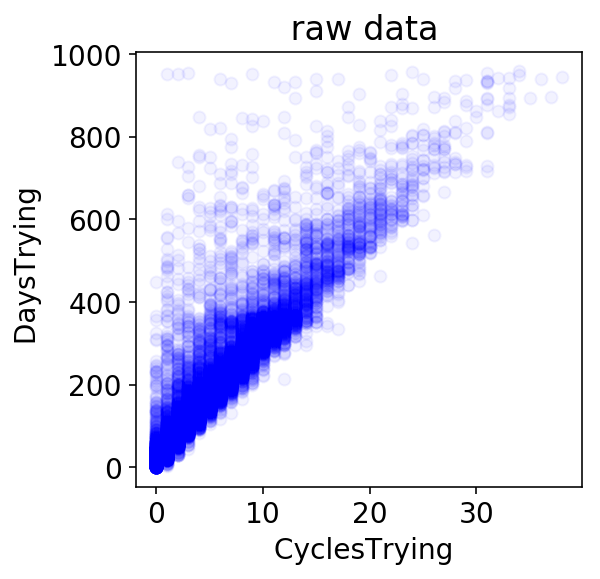

In [429]:
plot_scatter(data,0,' DaysTrying',' CyclesTrying',0,"raw data")

In [502]:
def split_X_raw(pregORdrop,X_raw,dropping):
   
    X_raw = X_raw.drop(rowsright)# over simplification
    if pregORdrop == 'PregancyRate':
        X_raw =  X_raw.drop(rowsdropout)
    if pregORdrop == 'DropoutRate':
        X_raw =  X_raw.drop(rowspregnant)

    if dropping ==1 :
        X_raw =  X_raw.drop(columns='  ExitStatus')#ExitStatus no longer needed
        if pregORdrop != 'pregORdrop':
            X_raw = X_raw.drop(columns=' DaysTrying')
            #X_raw = X_raw.drop(columns=' TempLogFreq')
            #X_raw = X_raw.drop(columns=' SexLogFreq')
            #X_raw = X_raw.drop(columns=' AnovCycles ')
            X_raw = X_raw.drop(columns=' CyclesTrying')
    return X_raw
    
#now encode the y_pregnant data
# class = 1 if DaysTrying(months trying) is less than N_months
def split_and_label_y_raw(pregORdrop,N_Months,y_raw):
    
    y_raw = y_raw.drop(rowsright)#temporary/simplest solution
    if pregORdrop == 'PregancyRate':
        y_raw = y_raw.drop(rowsdropout)
    if pregORdrop == 'DropoutRate':
        y_raw = y_raw.drop(rowspregnant)

    #y_raw = X_raw.as_matrix()[:,5]#DaysTrying #X[' DaysTrying'].as_matrix()
    #DaysTrying column
    y_raw = y_raw.as_matrix()
    y_raw = y_raw.ravel()
    threshold = N_Months*(365/12)
    if pregORdrop != 'pregORdrop':
        y_raw = np.take([0, 1],(y_raw < threshold)) 
  
    y_raw = y_raw.astype('int')
    return y_raw

def scale_X_data(X_raw):
    colsnames = X_raw.columns
    scaler = preprocessing.MinMaxScaler()
    X_raw = pd.DataFrame(scaler.fit_transform(X_raw))
    X_raw.columns = colsnames
    #X_raw.head()
    return X_raw

## Define a Random forest estimator
I do some  hyper-parameter optimization eventhought it is not really necessary as which are the most important features seems to be robust against changes the hyper-parameters (the absolute feature importances vary, but the trend is stable).

In [511]:
RFClf = RandomForestClassifier(n_estimators=150,max_depth = 50)

param_rscv = {
    "max_depth": np.arange(5,50,1),
    #"min_impurity_decrease": np.arange(0.02,0.2,0.02),
    #"max_features": np.arange(3,11,1),
    "bootstrap":[True,False],
    #"min_sample_split":np.arange(2,10,1)
}
rscv = RandomizedSearchCV(RFClf, param_distributions=param_rscv,n_iter=1)



### Define a function to train the estimator and plot feature importances

In [506]:
 def find_features_important_for_rate(pregORdrop,N_Months,X_train, X_test, y_train, y_test):
    rscv.fit(X_train,y_train)
    print(["train score = ",rscv.best_score_])
    print(["best parameters = ",rscv.best_params_])
    print(["test score = ",rscv.score(X_test,y_test)])

    importances = rscv.best_estimator_.feature_importances_
    #for f in range(X.shape[1]):
   # print( featurenames[f],",","importance = ",(importances[f]))
    plt.figure()
    titlestr1 = "Feature importances, %s" %(pregORdrop)
    titlestr2 = ", N_Months =%i" %(N_Months)
    plt.title(titlestr1+titlestr2)

    plt.bar(range(X_train.shape[1]), importances,color="b", align="center")
    plt.xticks(range(X_train.shape[1]), X_train.columns,rotation='vertical')
    plt.xlim([-1, X_train.shape[1]])
    plt.ylim([0, 0.4])

    plt.show()
    


## Factors that impact whether time to to become pregnant is less than N months
#### Feature importances
Feature importances are shown as bar graphs below. The most important features defining whether a cycler becomes pregnant before N months are the Sex Logging Frequency and Temperature Logging Frequency. The number of anovulatory cycles seems to become important for larger N, which would be logically reasonable, but it's importance is unstable with respect to changes of hyper parameters. These features are always the the most important, independent of the choice of N. The test score of the model improves for higher N.

#### Reality Check
To try to understand the sense in which TempLogFreq and SexLogFreq are important for the model, I plot scatter diagrams of the TempLogFreq and SexLogFreq for data that was not used to train the classifier. The colour of the blobs is either the label predicted by the classifier, or the label of the raw data for comparision. The scatter diagrams below show that for N=2 months the model predicts that cyclers with SexLogFreq towards the highest frequencies recorded, and with high TempLogFreq will be pregnant after 2 months of trying (pink blobs). For larger N, the model predicts that only the cyclers with both very low SexLogFreq and TempLogFreq will not be pregnant.

<br>If one assumes that the sex logging frequency is proportional to actual instances of sex, it makes sense that this should influence pregnancy rate. In this case, the model prediction fits the reality check that higher SexLogFreq leads to pregnancy in shorter time. 

<br>It is more tricky to imagine a reality check for TempLogFreq. Logging temperature with a higher or lower frequency will have an impact on the number of red/green days that the cycler gets. If one assumes a correlation between red days (cycler is fertile) and instances of sex, higher logging frequency could be expected to lead to greater chances of pregnancy. A less explicit link might be that a cycler logging more frequently is more invested in the planning process and more diligent about optimizing their use of green days. The model fits with these two rather weak reality checks.

['train score = ', 0.79099779666351899]
['best parameters = ', {'max_depth': 29, 'bootstrap': False}]
['test score = ', 0.78351164254247951]


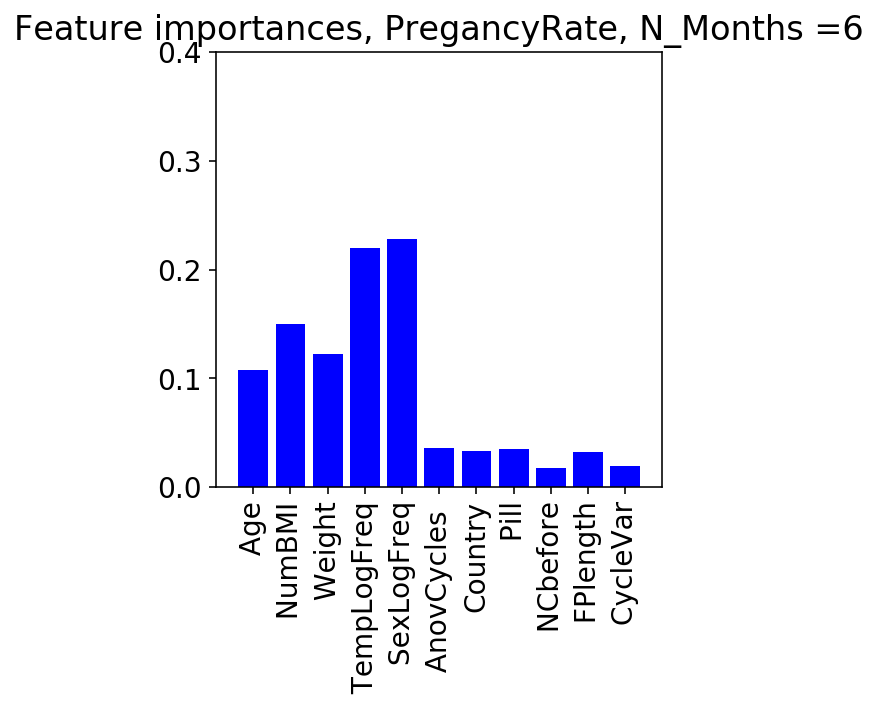

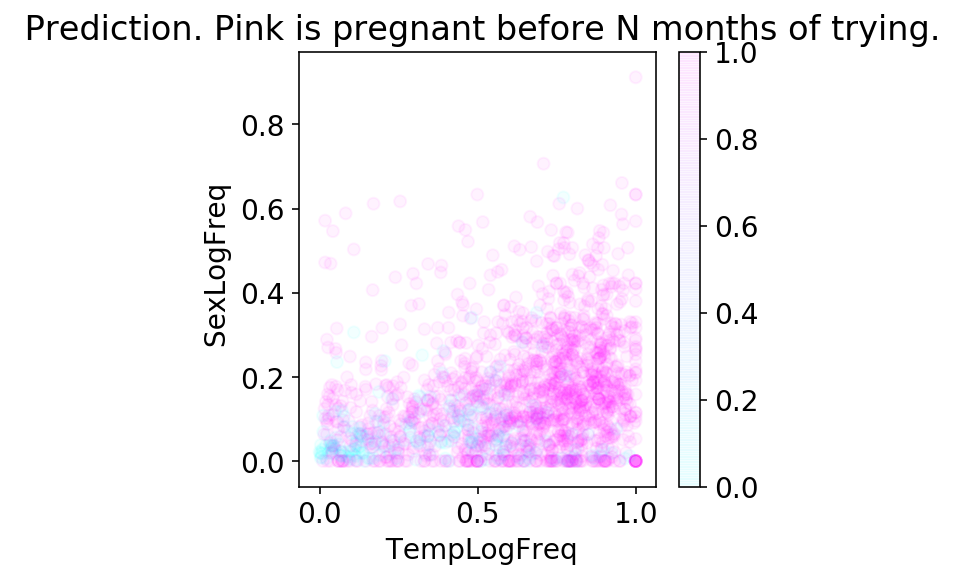

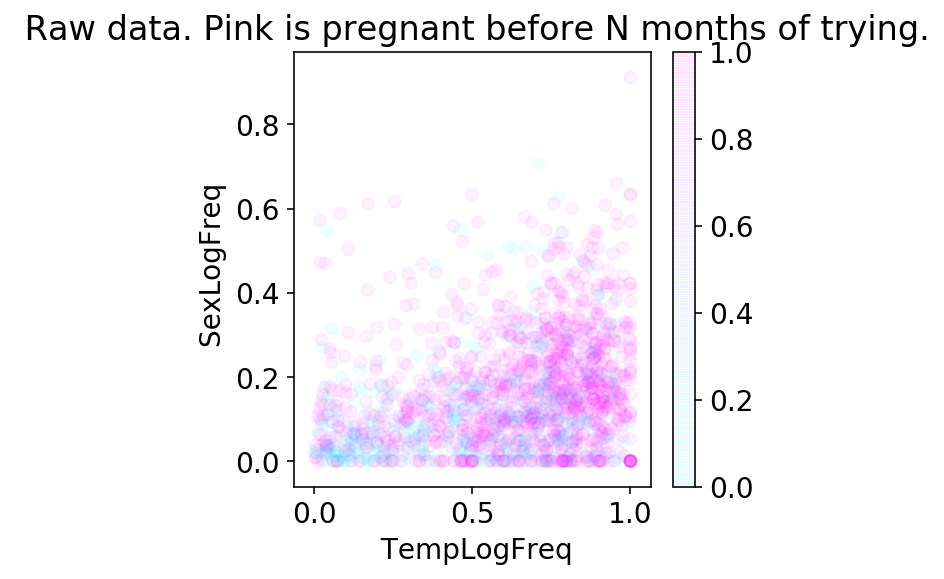

In [513]:
month_threshold = 6
X_pregnant = X
y_pregnant = X[' DaysTrying']
X_pregnant = split_X_raw('PregancyRate',X_pregnant,1)
X_pregnant = scale_X_data(X_pregnant)
y_pregnant = split_and_label_y_raw('PregancyRate',month_threshold,y_pregnant)
X_train, X_test, y_train, y_test = train_test_split(X_pregnant, 
                                                    y_pregnant,train_size=0.8,
                                                    test_size=0.2)
find_features_important_for_rate('PregancyRate',month_threshold,X_train, X_test, y_train, y_test)
titlestr1 = "Prediction. Pink is pregnant before N months of trying."
plot_scatter(X_test,rscv.predict(X_test), ' SexLogFreq',' TempLogFreq',1,titlestr1)
titlestr2 = "Raw data. Pink is pregnant before N months of trying."
plot_scatter(X_test,y_test, ' SexLogFreq',' TempLogFreq',1,titlestr2)
#plot_scatter(X_test,y_test, ' Age',' Weight',1,titlestr2)

## Factors that impact whether a dropout cycler does so before N months
Feture importances for N = 2, 5 and 9 months are shown by bar charts below. As for the pregnant cyclers, SexLogFreq and TempLogFreq are the most important features for predicting dropout before the threshold N months.
#### Reality Check
From the scatter plots of the label predicted by the model as a function of SexLogFreq and TempLogFreq, we see that the model predicts that high logging frequency indicates an early dropout. I find it counter intuitive that high logging sex and temperature frequencies lead to earlier dropout. Perhaps it is indicative that people tend to log more when they start and log less and less as time goes on leading to an overall low logging frequency. Depending on how the SexLogFreq and TempLogFreq features are calculated this may be exacerbated for cyclers that have high number of DaysTrying. 


<br>Indeed, SexLogFreq, TempLogFreq and AnovCycles all have an implicit time dependence. Since they are important for both the Pregnant and dropout data sets in an apparently similar way, I suspect that their iplicit or explicit relationship to daystrying, which was used to label the data, is biasing their importance. It might be interesting to re-run the analysis but ignoring the time-dependent features to see if there are any decisive features that are independent of DaysTrying (for example Pill or Age).

<br> I did a quick test of excluding the time dependent features, and then Age, BMI and Weight become the most important for both PRegnant and Dropout cyclers. These are the only three continuous varables left in the data set. To me this suggest a problem with the model and the approach in general.


['train score = ', 0.75521448248720979]
['best parameters = ', {'max_depth': 10, 'bootstrap': False}]
['test score = ', 0.7581322140608604]


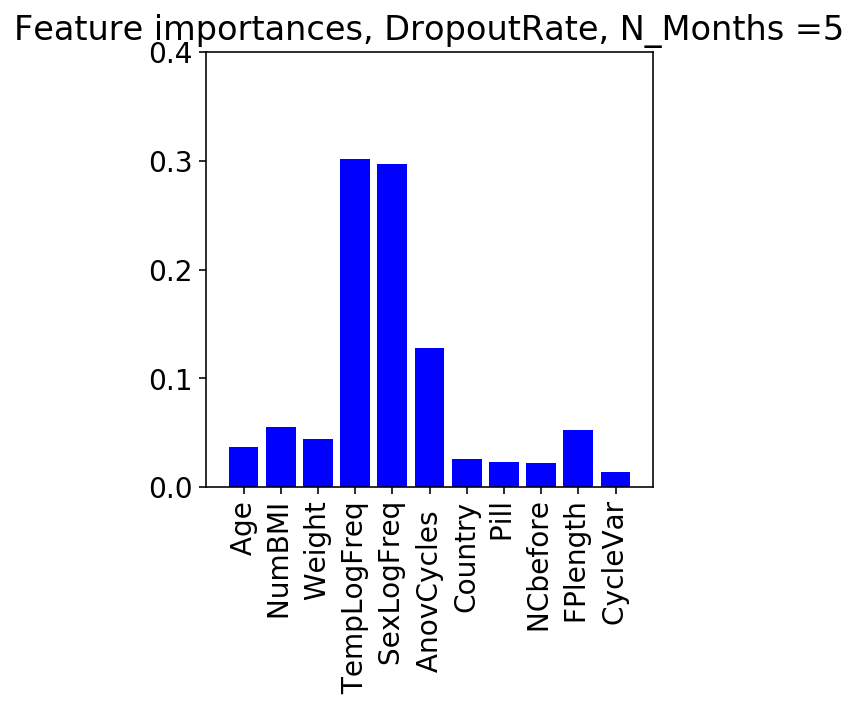

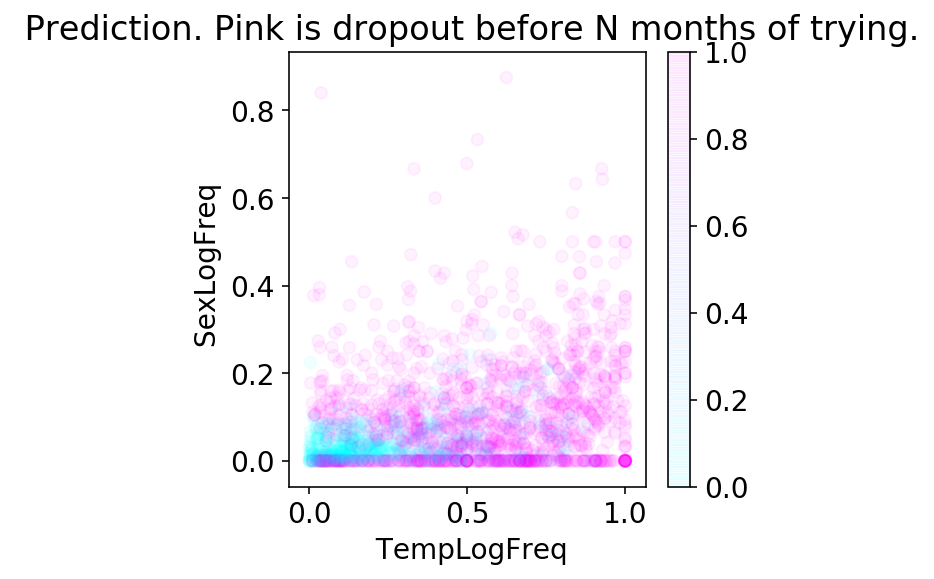

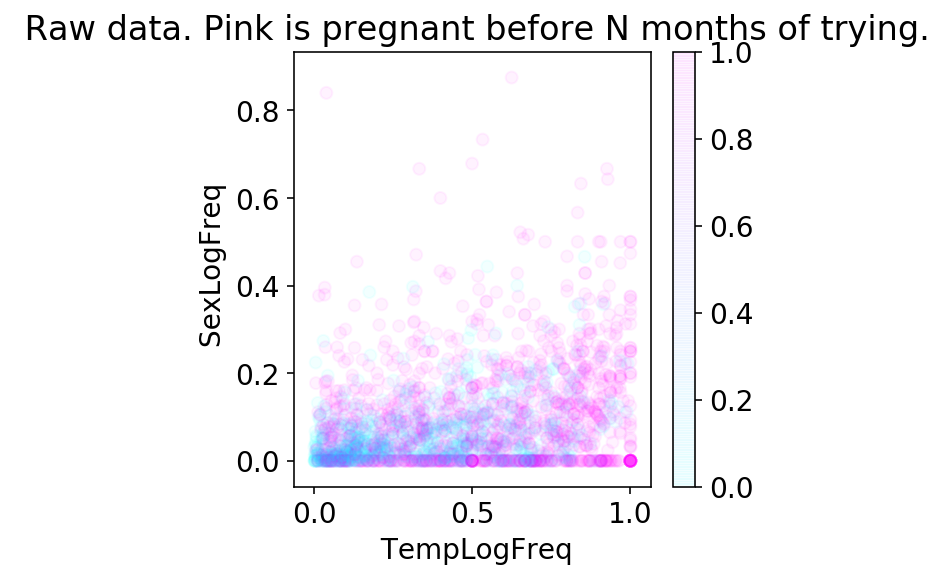

In [514]:
month_threshold = 5
X_dropout = X
y_dropout = X[' DaysTrying']
X_dropout = split_X_raw('DropoutRate',X_dropout,1)
X_dropout = scale_X_data(X_dropout)
y_dropout = split_and_label_y_raw('DropoutRate',month_threshold,y_dropout)
X_train, X_test, y_train, y_test = train_test_split(X_dropout, 
                                                    y_dropout,train_size=0.8,
                                                    test_size=0.2)
find_features_important_for_rate('DropoutRate',month_threshold,X_train, X_test, y_train, y_test)
titlestr3 = "Prediction. Pink is dropout before N months of trying."
plot_scatter(X_test,rscv.predict(X_test), ' SexLogFreq',' TempLogFreq',1,titlestr3)
plot_scatter(X_test,y_test, ' SexLogFreq',' TempLogFreq',1,titlestr2)

#### Raw data for important features: Dropout 
In the scatter plots below, there is a feature in the data for dropouts at exactly 1 year of DaysTrying. This vertical feature at 365 days is for a broad range of TempLogFreq and SexLogFreq and breaks the otherwise smooth distribution of cyclers. To me, this suggests people drop out because of some external influence. For example perhaps their subscription ends or is not renewed?

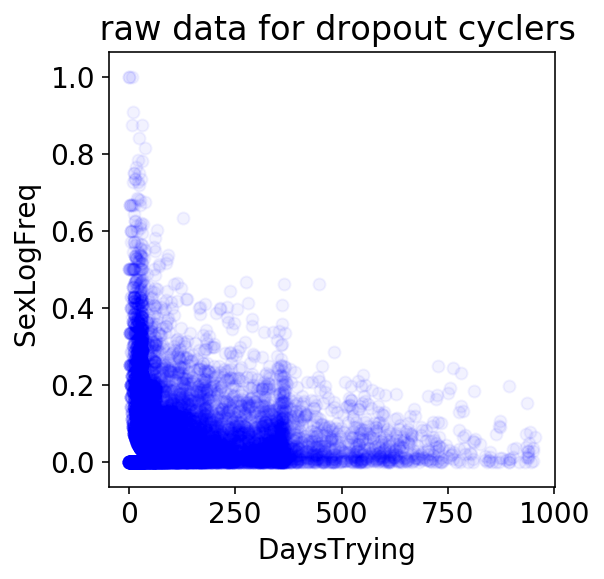

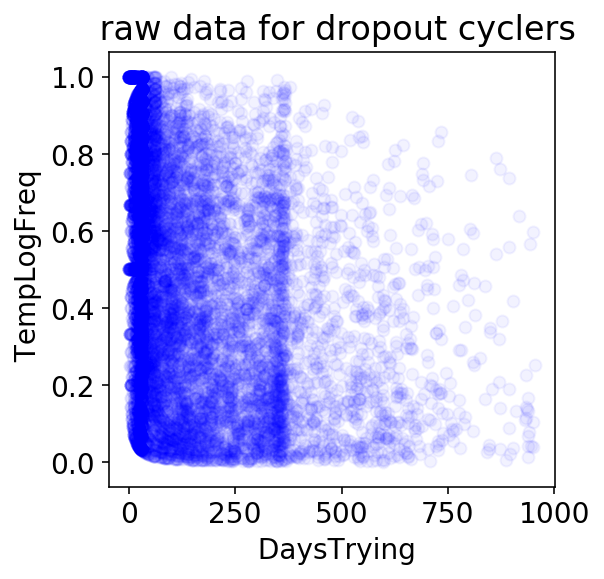

In [473]:
X_dropout = X
X_dropout = split_X_raw('DropoutRate',X_dropout,0)
plot_scatter(X_dropout,0,' SexLogFreq',' DaysTrying',0,"raw data for dropout cyclers")
plot_scatter(X_dropout,0,' TempLogFreq',' DaysTrying',0,"raw data for dropout cyclers")

## Pregnant or Dropout?
If TempLogFreq and SexLogFreq are both important for defining the timescale over which a cycler falls pregnant or drops out, then what features distinguish the two types of cyclers? Here I take the full data set (minus the Right cyclers) and label them according to their Exitstatus. 1 = Pregnant. 0 = Dropout. DaysTrying becomes important in helping the model predict.

['train score = ', 0.70616012019746732]
['best parameters = ', {'max_features': 6, 'max_depth': 12, 'bootstrap': True}]
['test score = ', 0.70271816881258942]


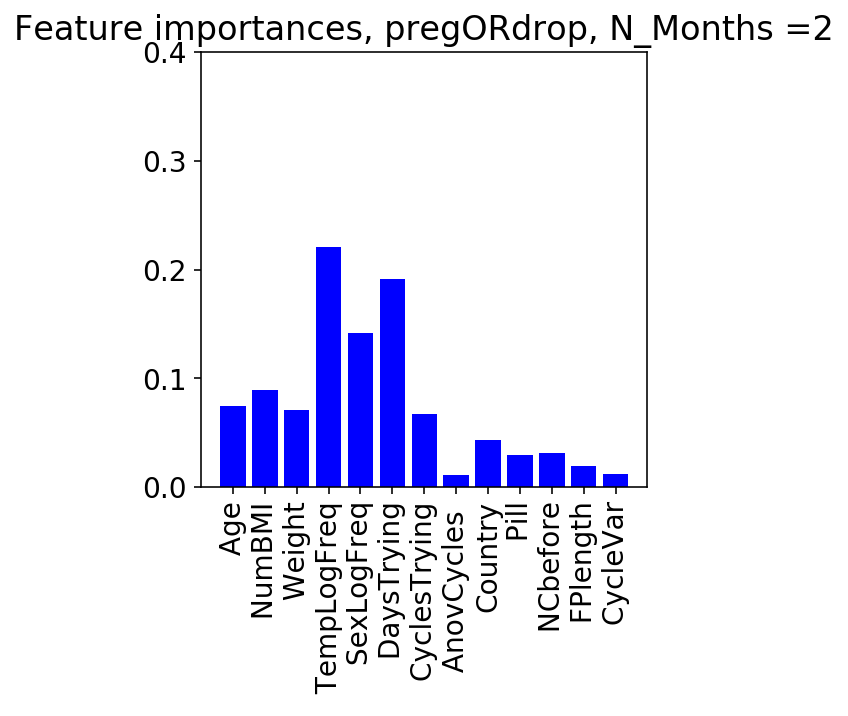

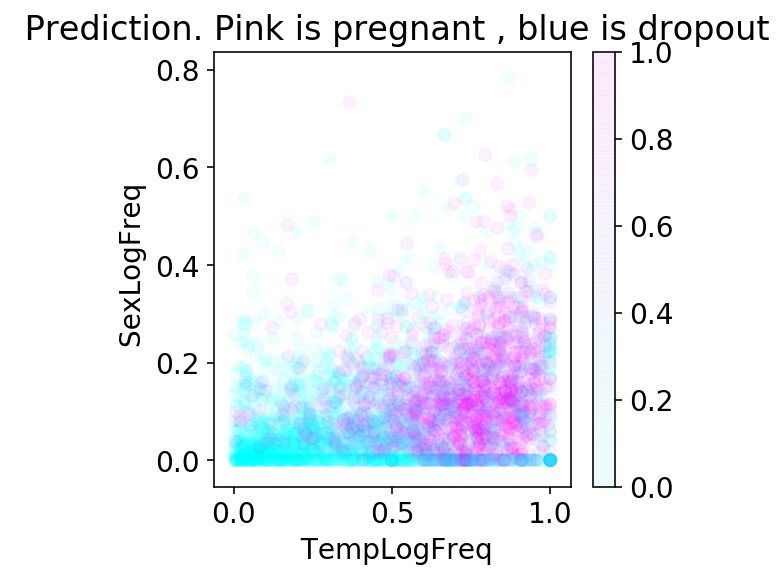

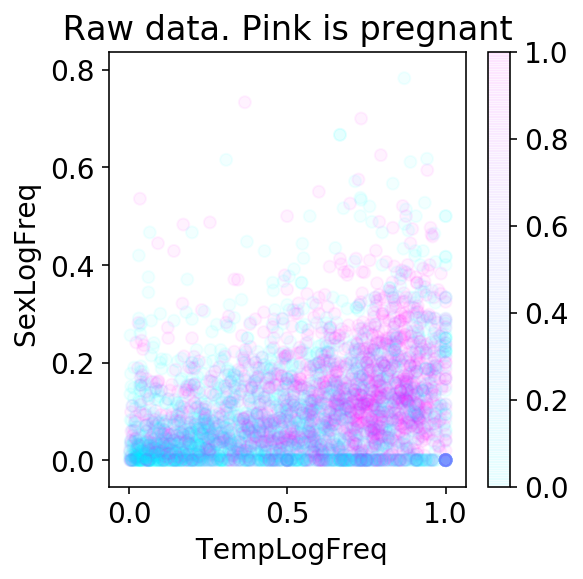

In [474]:
dummy = 2
X_pORd = X
y_pORd = X['  ExitStatus']
X_pORd = split_X_raw('pregORdrop',X_pORd,1)
X_pORd = scale_X_data(X_pORd)
y_pORd = split_and_label_y_raw('pregORdrop',dummy,y_pORd)
X_train, X_test, y_train, y_test = train_test_split(X_pORd, 
                                                    y_pORd,train_size=0.8,
                                                    test_size=0.2)
find_features_important_for_rate('pregORdrop',dummy,X_train, X_test, y_train, y_test)
titlestr1 = "Prediction. Pink is pregnant , blue is dropout"
plot_scatter(X_test,rscv.predict(X_test), ' SexLogFreq',' TempLogFreq',1,titlestr1)
titlestr2 = "Raw data. Pink is pregnant "
plot_scatter(X_test,y_test, ' SexLogFreq',' TempLogFreq',1,titlestr2)